<a href="https://colab.research.google.com/github/UritiSrikanth/Assignment-3--LLM-coding-and-report-submission/blob/main/Assignment_3_LLM_coding_and_report_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [2]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, TrainerCallback
import evaluate
import numpy as np
import torch
from wordcloud import WordCloud


We start by loading the dataset using the load_dataset function from the datasets library. In this case, we load the "**fka/awesome-chatgpt-prompts**" dataset, which contains columns 'act' and 'prompt'.

In [3]:
# Step 1: Load the dataset
dataset = load_dataset("fka/awesome-chatgpt-prompts")
# Print the dataset structure
print("Dataset structure:", dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/153 [00:00<?, ? examples/s]

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 153
    })
})


In [4]:
# Load the dataset
dataset = load_dataset("fka/awesome-chatgpt-prompts")

# Print the dataset structure
print("Dataset structure:", dataset)

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 153
    })
})


In [5]:
# Check the first few entries to understand the data
print(dataset['train'][:5])

# Analyze the 'act' column to understand the distribution
acts = [entry['act'] for entry in dataset['train']]
unique_acts, counts = np.unique(acts, return_counts=True)

# Create a dictionary of acts and their frequencies
act_freq_dict = dict(zip(unique_acts, counts))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(act_freq_dict)


{'act': ['Linux Terminal', 'English Translator and Improver', '`position` Interviewer', 'JavaScript Console', 'Excel Sheet'], 'prompt': ['I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd', 'I want you to act as an English translator, spelling corrector and improver. I will speak to you in any language and you will detect the language, translate it and answer in the corrected and improved version of my text, in English. I want you to replace my simplified A0-level words and sentences with more beautiful and elegant, upper level English words and sentences. Keep the meaning same, but make them more literary. I want y

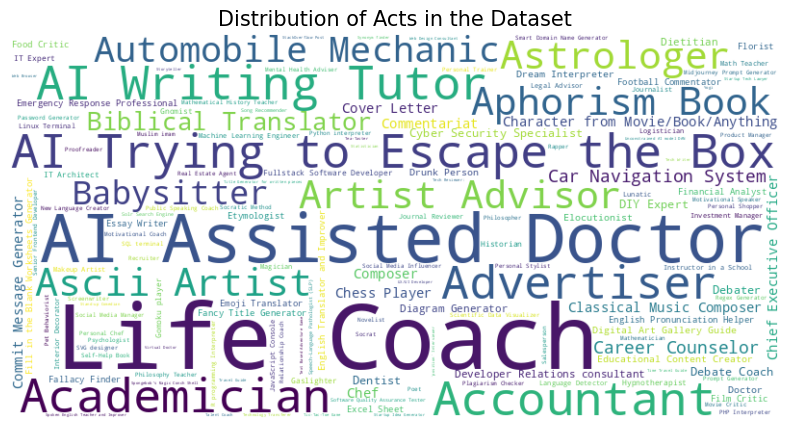

In [6]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Distribution of Acts in the Dataset', fontsize=15)
plt.show()

Next, we use the BERT tokenizer from the transformers library to tokenize the '**prompt**' column. The tokenize_function is defined to apply padding and truncation to the tokenized outputs, ensuring that all sequences have the same length. We then map this tokenization function to the dataset using the map method, which processes the dataset in batches for efficiency.

In [7]:
# Step 2: Tokenize the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

Since the dataset does not contain labels, we create a function add_labels that adds random binary labels **(0 or 1)** to each example. This simulates a classification problem, enabling us to train and evaluate the model. We map this function to the tokenized dataset, generating a labeled dataset. We use the DataCollatorWithPadding to create batches of data with uniform lengths, which is necessary for efficient training on the GPU. The tokenized dataset is then split into training and evaluation subsets using an 90-10 split, providing separate data for training and validation.

In [8]:
# Step 3: Add dummy labels to the dataset (e.g., binary classification)
import random

def add_labels(examples):
    examples['labels'] = [random.randint(0, 1) for _ in range(len(examples['prompt']))]
    return examples

tokenized_dataset = tokenized_dataset.map(add_labels, batched=True)

# Prepare data for training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Split dataset into training and evaluation
tokenized_dataset = tokenized_dataset['train'].train_test_split(test_size=0.1)
train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['test']

Map:   0%|          | 0/153 [00:00<?, ? examples/s]

We initialize a BertForSequenceClassification model with two output labels, suitable for binary classification. We define TrainingArguments, specifying various training configurations like the output directory, evaluation strategy, logging settings, learning rate, batch sizes, number of epochs, and weight decay for regularization. We load the accuracy metric using the evaluate library and define the compute_metrics function to calculate accuracy from the model's predictions and the true labels. This function will be used during evaluation to track model performance. To log training and evaluation metrics, we create a custom MetricsCallback class that inherits from TrainerCallback. This class logs training loss, evaluation loss, training accuracy, and evaluation accuracy. The on_log method captures these metrics during training, and the on_epoch_end method computes training accuracy at the end of each epoch by iterating over the training dataloader and comparing predictions to true labels.




In [9]:
# Step 4: Set up the Trainer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# Define the evaluation metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [11]:
# Callback to log the training and evaluation metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.train_acc = []
        self.eval_acc = []

In [12]:
 def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_loss.append((state.global_step, logs['loss']))
            if 'eval_loss' in logs:
                self.eval_loss.append((state.global_step, logs['eval_loss']))
            if 'eval_accuracy' in logs:
                self.eval_acc.append((state.global_step, logs['eval_accuracy']))


In [13]:
def on_epoch_end(self, args, state, control, **kwargs):
        # Compute accuracy on training dataset at the end of each epoch
        train_dataloader = trainer.get_train_dataloader()
        model.eval()
        total_correct = 0
        total_samples = 0
        for batch in train_dataloader:
            inputs = {k: v.to(args.device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**inputs)
            predictions = outputs.logits.argmax(dim=-1)
            total_correct += (predictions == inputs['labels']).sum().item()
            total_samples += predictions.size(0)
        train_accuracy = total_correct / total_samples
        self.train_acc.append((state.global_step, train_accuracy))

In [14]:
metrics_callback = MetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback],
)